In [1]:
import torch 
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:3]

['emma', 'olivia', 'ava']

In [3]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i:s for s, i in stoi.items()}
itos

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

In [4]:
block_size = 3
X, Y = [], []

for w in words:
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

In [5]:
def build_dataset(words):
    block_size = 5
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random 
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 5]) torch.Size([182625])
torch.Size([22655, 5]) torch.Size([22655])
torch.Size([22866, 5]) torch.Size([22866])


In [53]:
n_emb = 10
n_hidden = 200
block_size = 5
vocab_size = len(itos.keys())

C = torch.randn((vocab_size, n_emb))
W1 = torch.randn((n_emb*block_size, n_hidden)) * (5/3) / ((n_emb * block_size)**0.5)
b1 = torch.randn(n_hidden) * 0.01
W2 = torch.randn((n_hidden, vocab_size)) * 0.0001
b2 = torch.randn(vocab_size) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b1, b2, bngain, bnbias]
sum(p.nelement() for p in parameters)
for p in parameters:
    p.requires_grad = True

tensor(0.0038) tensor(1.0018)
tensor(-0.0058) tensor(1.0131)


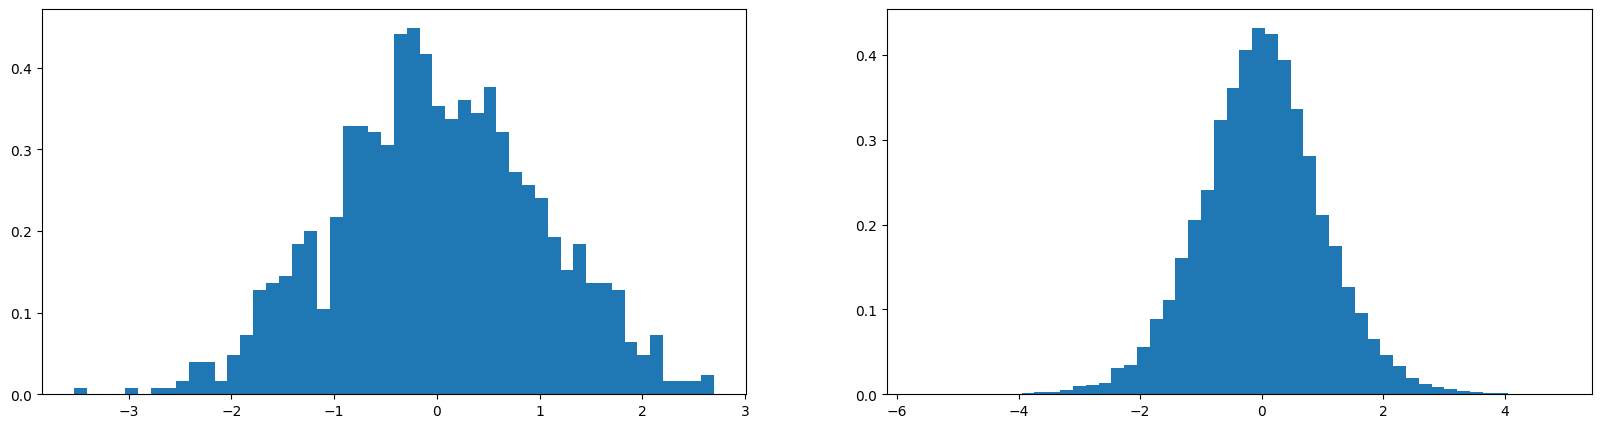

In [54]:
x = torch.randn(100, 10)
w = torch.randn(10, 200) / 10**0.5
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

In [55]:
(5/3) / (30**0.5) # Kaiming init --> gain / sqrt(fan_in); fan_in = input size 

0.3042903097250923

In [ ]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps+1):
    # making batches
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Y[ix]

    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running  + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running  + 0.001 * bnstdi
        

    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])

    # backwards pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    if i % 10000 == 0:
        print(f"Epoch: {i}/{max_steps} Loss: {loss.item()}")
    lossi.append(loss.item())

Epoch: 0/200000 Loss: 1.9961851835250854
Epoch: 10000/200000 Loss: 1.7637161016464233
Epoch: 20000/200000 Loss: 1.8161914348602295
Epoch: 30000/200000 Loss: 2.146851062774658
Epoch: 40000/200000 Loss: 2.0047264099121094
Epoch: 50000/200000 Loss: 1.998539924621582
Epoch: 60000/200000 Loss: 2.2927443981170654
Epoch: 70000/200000 Loss: 2.0485594272613525
Epoch: 80000/200000 Loss: 2.0882222652435303
Epoch: 90000/200000 Loss: 2.0280423164367676
Epoch: 100000/200000 Loss: 2.2330453395843506
Epoch: 110000/200000 Loss: 2.203343152999878
Epoch: 120000/200000 Loss: 1.9287623167037964
Epoch: 130000/200000 Loss: 2.05985426902771
Epoch: 140000/200000 Loss: 1.8728792667388916
Epoch: 150000/200000 Loss: 1.656852126121521
Epoch: 160000/200000 Loss: 1.8556185960769653
Epoch: 170000/200000 Loss: 1.814637303352356
Epoch: 180000/200000 Loss: 2.5165622234344482
Epoch: 190000/200000 Loss: 2.459432363510132
Epoch: 200000/200000 Loss: 1.7735720872879028


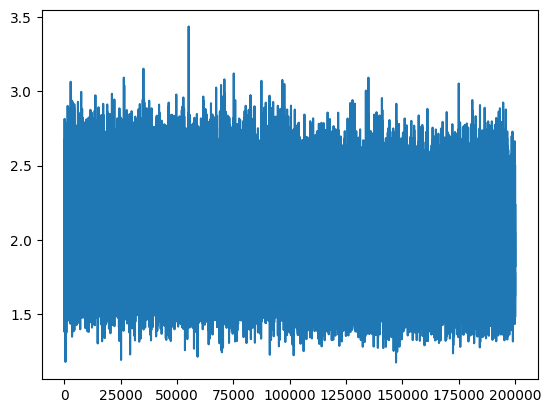

In [65]:
plt.plot(lossi)

In [66]:
# Calibrate batch norm after training 

with torch.no_grad():
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    # measure the mean/ std over the entire training set 
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [70]:
@torch.no_grad
def split_loss(split):
    x, y = {
        'train' : (Xtr, Ytr),
        'val' : (Xdev, Ydev),
        'test' : (Xte, Yte)
    }[split]

    emb = C[x]
    hpreact = emb.view(emb.shape[0], -1) @ W1 + b1
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')


train 1.9372224807739258
val 2.0352718830108643


In [71]:
block_size = 5
for _ in range(20):
    out = []
    context = [0] * block_size

    while True:
        emb = C[torch.tensor([context])]
        hpreact = emb.view(1, -1) @ W1 + b1
        hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias
        h = torch.tanh(hpreact)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, replacement=True)
        context = context[1:] + [ix]
        out.append(itos[ix.item()])
        if ix == 0:
            print(''.join(out[:-1]))
            out = []
            break 

miljar
melca
layana
malenna
vyanne
haamia
keyani
taes
julissef
visel
tirabella
anavia
jennico
aracharika
lyon
jamir
faris
kamone
kritha
tzyjien


# Loss Log:
#### Original
- train: 2.12
- val: 2.15
#### Fix softmax distribution probability
- train: 2.07
- val: 2.13 

#### Fix tanh layer being to saturated at init
- train: 1.90
- val: 2.04

#### Implemented Kaiming init 
- train: 1.90
- val: 2.05

#### Added a batch norm layer
- train: 1.93
- val: 2.03

# Deeper Network

In [2]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.5):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters trained with backprop
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    
    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean 
            xvar = x.var(0, keepdim=True) # batch variance 
        else:
            xmean = self.running_mean
            xvar = self.running_var
        
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean 
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

    class Tanh:
        def __call__(self, x):
            self.out = torch.tanh(x)
            return self.out
        def parameters(self):
            return []